#  Pacotes importantes

In [1]:
%pip install timm scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


# Dataset

In [3]:
import torchvision
from torchvision import transforms
from torch.utils.data import random_split, DataLoader, Subset
from torch.utils.data.dataloader import default_collate
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

## Classe

In [4]:
super_map = {
    0: 4,   # apple → fruit and vegetables
    1: 1,   # aquarium_fish → fish
    2: 14,  # baby → people
    3: 8,   # bear → large carnivores
    4: 0,   # beaver → aquatic mammals
    5: 6,   # bed → household furniture
    6: 7,   # bee → insects
    7: 7,   # beetle → insects
    8: 18,  # bicycle → vehicles 1
    9: 3,   # bottle → food containers
    10: 3,  # bowl → food containers
    11: 14, # boy → people
    12: 9,  # bridge → large man-made outdoor things
    13: 18, # bus → vehicles 1
    14: 7,  # butterfly → insects
    15: 11, # camel → large omnivores and herbivores
    16: 3,  # can → food containers
    17: 9,  # castle → large man-made outdoor things
    18: 7,  # caterpillar → insects
    19: 11, # cattle → large omnivores and herbivores
    20: 6,  # chair → household furniture
    21: 11, # chimpanzee → large omnivores and herbivores
    22: 5,  # clock → household electrical devices
    23: 10, # cloud → large natural outdoor scenes
    24: 7,  # cockroach → insects
    25: 6,  # couch → household furniture
    26: 13, # crab → non-insect invertebrates
    27: 15, # crocodile → reptiles
    28: 3,  # cup → food containers
    29: 15, # dinosaur → reptiles
    30: 0,  # dolphin → aquatic mammals
    31: 11, # elephant → large omnivores and herbivores
    32: 1,  # flatfish → fish
    33: 10, # forest → large natural outdoor scenes
    34: 12, # fox → medium-sized mammals
    35: 14, # girl → people
    36: 16, # hamster → small mammals
    37: 9,  # house → large man-made outdoor things
    38: 11, # kangaroo → large omnivores and herbivores
    39: 5,  # keyboard → household electrical devices
    40: 5,  # lamp → household electrical devices
    41: 19, # lawn_mower → vehicles 2
    42: 8,  # leopard → large carnivores
    43: 8,  # lion → large carnivores
    44: 15, # lizard → reptiles
    45: 13, # lobster → non-insect invertebrates
    46: 14, # man → people
    47: 17, # maple → trees
    48: 18, # motorcycle → vehicles 1
    49: 10, # mountain → large natural outdoor scenes
    50: 16, # mouse → small mammals
    51: 4,  # mushroom → fruit and vegetables
    52: 17, # oak → trees
    53: 4,  # orange → fruit and vegetables
    54: 2,  # orchid → flowers
    55: 0,  # otter → aquatic mammals
    56: 17, # palm → trees
    57: 4,  # pear → fruit and vegetables
    58: 18, # pickup_truck → vehicles 1
    59: 17, # pine → trees
    60: 10, # plain → large natural outdoor scenes
    61: 3,  # plate → food containers
    62: 2,  # poppy → flowers
    63: 12, # porcupine → medium-sized mammals
    64: 12, # possum → medium-sized mammals
    65: 16, # rabbit → small mammals
    66: 12, # raccoon → medium-sized mammals
    67: 1,  # ray → fish
    68: 9,  # road → large man-made outdoor things
    69: 19, # rocket → vehicles 2
    70: 2,  # rose → flowers
    71: 10, # sea → large natural outdoor scenes
    72: 0,  # seal → aquatic mammals
    73: 1,  # shark → fish
    74: 16, # shrew → small mammals
    75: 12, # skunk → medium-sized mammals
    76: 9,  # skyscraper → large man-made outdoor things
    77: 13, # snail → non-insect invertebrates
    78: 15, # snake → reptiles
    79: 13, # spider → non-insect invertebrates
    80: 16, # squirrel → small mammals
    81: 19, # streetcar → vehicles 2
    82: 2,  # sunflower → flowers
    83: 4,  # sweet_pepper → fruit and vegetables
    84: 6,  # table → household furniture
    85: 19, # tank → vehicles 2
    86: 5,  # telephone → household electrical devices
    87: 5,  # television → household electrical devices
    88: 8,  # tiger → large carnivores
    89: 19, # tractor → vehicles 2
    90: 18, # train → vehicles 1
    91: 1,  # trout → fish
    92: 2,  # tulip → flowers
    93: 15, # turtle → reptiles
    94: 6,  # wardrobe → household furniture
    95: 0,  # whale → aquatic mammals
    96: 17, # willow → trees
    97: 8,  # wolf → large carnivores
    98: 14, # woman → people
    99: 14  # woman → people (duplicado caso precise)
}


In [5]:
class CIFAR100_MultiTargets(torchvision.datasets.CIFAR100):
    def __init__(self, root, train, transform, download=False, super_map=None, ten_map=None):
        super().__init__(root, train=train, transform=transform, download=download)
        self.super_map = super_map
        self.ten_map = ten_map

    def __getitem__(self, index):
        img, target100 = super().__getitem__(index)
        target20 = self.super_map[target100]
        return img, target100, target20


## Loading do dataset

In [6]:
transform_train = transforms.Compose([
    transforms.Resize(224),                      # redimensiona para o tamanho do EfficientNet
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.2)),
    transforms.Normalize([0.485, 0.456, 0.406],  # valores do ImageNet
                         [0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

In [7]:
trainset = CIFAR100_MultiTargets(
    root='./data',
    train=True,
    transform=transform_train,
    download=True,
    super_map=super_map,
)

testset = CIFAR100_MultiTargets(
    root='./data',
    train=False,
    transform=transform_test,
    download=True,
    super_map=super_map,
)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
targets = np.array(trainset.targets)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(np.zeros(len(targets)), targets))

train_data = Subset(trainset, train_idx)
val_data = Subset(trainset, val_idx)


# ============================================================
# 🚀 Dataloaders finais
# ============================================================
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
val_loader   = DataLoader(val_data,   batch_size=64, shuffle=False, num_workers=8, pin_memory=True)
test_loader  = DataLoader(testset,    batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

print(f"✅ Treino: {len(train_data)} imagens")
print(f"✅ Validação: {len(val_data)} imagens")
print(f"✅ Teste: {len(testset)} imagens")

✅ Treino: 40000 imagens
✅ Validação: 10000 imagens
✅ Teste: 10000 imagens


# Modelo

In [9]:
import torch
import torch.nn as nn
import torchvision

## Multi-Head Model

In [10]:
class MultiHeadModel(nn.Module):
    def __init__(self, backbone, embedding_dim, n_head1=20, n_head2=100):
        super().__init__()
        self.backbone = backbone  # backbone should output feature map
        # Example: backbone returns C x 1 x 1 after avgpool or return features and we apply avgpool.
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        # heads: small MLPs
        self.head1 = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, n_head1)
        )
        self.head2 = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, n_head2)
        )
    def forward(self, x):
        x = self.backbone(x)                 # could be features or logits depending on model
        x = self.avgpool(x)
        x = self.flatten(x)                  # shape (B, embedding_dim)
        out1 = self.head1(x)
        out2 = self.head2(x)
        return out1, out2


## Super Class Model

In [45]:
class SuperClass20Model(nn.Module):
    def __init__(self, backbone, embedding_dim, n_head1=10, n_head2=100):
        super().__init__()
        self.backbone = backbone
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()

        self.head = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, n_head1)
        )

        # Inicializa pesos da cabeça
        self._init_head_weights()

    def _init_head_weights(self):
        """Inicializa pesos das camadas lineares da cabeça com Xavier uniform."""
        for m in self.head:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.backbone(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        out = self.head(x)
        return out


## 100 Class Model

In [57]:
class Class100Model(nn.Module):
    def __init__(self, backbone, embedding_dim, n_head=100):
        super().__init__()
        self.backbone = backbone
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()

        self.head = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, n_head)
        )

        # Inicializa pesos da cabeça
        self._init_head_weights()

    def _init_head_weights(self):
        """Inicializa pesos das camadas lineares da cabeça com Xavier uniform."""
        for m in self.head:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.backbone(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        out = self.head(x)
        return out


# Treinamento

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

## Multi-head Model

/home/carlos/Desktop/trabalho_1_RN/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/carlos/Desktop/trabalho_1_RN/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Usando: cuda


🌟 Época 1/20
Treino: loss=2.1534, acc20=65.32%, acc100=50.22%
Validação: loss=1.5481, acc20=80.52%, acc100=69.48%


🌟 Época 2/20
Treino: loss=1.5620, acc20=80.09%, acc100=69.72%
Validação: loss=1.4209, acc20=83.85%, acc100=74.40%


🌟 Época 3/20
Treino: loss=1.4219, acc20=84.00%, acc100=74.92%
Validação: loss=1.3774, acc20=85.73%, acc100=76.15%


🌟 Época 4/20
Treino: loss=1.3315, acc20=86.45%, acc100=78.60%
Validação: loss=1.3485, acc20=86.44%, acc100=76.79%


🌟 Época 5/20
Treino: loss=1.2729, acc20=88.05%, acc100=80.84%
Validação: loss=1.3098, acc20=87.28%, acc100=78.38%


🌟 Época 6/20
Treino: loss=1.2120, acc20=89.58%, acc100=83.36%
Validação: loss=1.2837, acc20=88.02%, acc100=79.58%


🌟 Época 7/20
Treino: loss=1.1669, acc20=90.86%, acc100=85.23%
Validação: loss=1.2752, acc20=88.15%, acc100=80.15%


🌟 Época 8/20
Treino: loss=1.1304, acc20=91.85%, acc100=86.67%
Validação: loss=1.2665, acc20=88.69%, acc100=79.95%


🌟 Época 9/20
Treino: loss=1.0984, acc20=92.46%, acc100=88.25%
Validação: loss=1.2629, acc20=88.89%, acc100=80.34%


🌟 Época 10/20
Treino: loss=1.0739, acc20=93.03%, acc100=89.35%
Validação: loss=1.2477, acc20=89.35%, acc100=80.85%


🌟 Época 11/20
Treino: loss=1.0500, acc20=93.82%, acc100=90.20%
Validação: loss=1.2382, acc20=89.14%, acc100=81.27%


🌟 Época 12/20
Treino: loss=1.0256, acc20=94.12%, acc100=91.39%
Validação: loss=1.2454, acc20=89.35%, acc100=80.95%


🌟 Época 13/20
Treino: loss=1.0064, acc20=94.70%, acc100=92.33%
Validação: loss=1.2258, acc20=89.75%, acc100=82.30%


🌟 Época 14/20
Treino: loss=0.9918, acc20=95.08%, acc100=92.78%
Validação: loss=1.2239, acc20=89.44%, acc100=81.81%


🌟 Época 15/20
Treino: loss=0.9829, acc20=95.27%, acc100=93.16%
Validação: loss=1.2170, acc20=89.83%, acc100=82.16%


🌟 Época 16/20
Treino: loss=0.9698, acc20=95.64%, acc100=93.72%
Validação: loss=1.2153, acc20=90.04%, acc100=82.26%


🌟 Época 17/20
Treino: loss=0.9634, acc20=95.92%, acc100=94.01%
Validação: loss=1.2243, acc20=89.35%, acc100=81.97%


🌟 Época 18/20
Treino: loss=0.9575, acc20=95.88%, acc100=94.36%
Validação: loss=1.2103, acc20=89.95%, acc100=82.54%


🌟 Época 19/20
Treino: loss=0.9541, acc20=95.91%, acc100=94.48%
Validação: loss=1.2056, acc20=89.87%, acc100=82.58%


🌟 Época 20/20
Treino: loss=0.9550, acc20=96.02%, acc100=94.33%
Validação: loss=1.2106, acc20=89.82%, acc100=82.21%


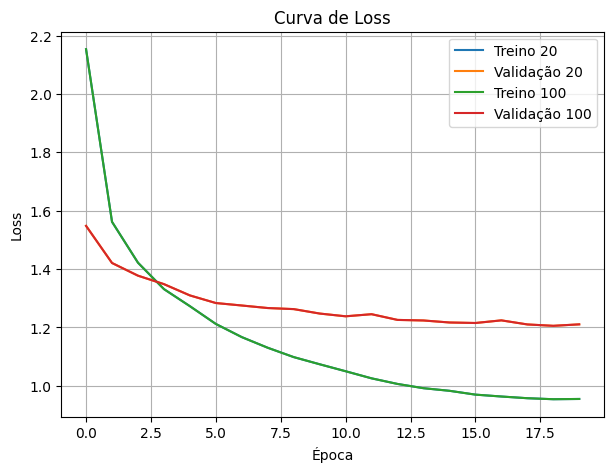

In [ ]:
# Definir dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

# Instanciar o modelo
backbone = torchvision.models.efficientnet_b0(pretrained=True)
backbone = nn.Sequential(*list(backbone.children())[:-2])  # remove avgpool e fc
model = MultiHeadModel(backbone, embedding_dim=1280, n_head1=20, n_head2=100).to(device)

# Definir otimizador e função de perda
optimizer = torch.optim.Adam([
    {'params': model.backbone.parameters(), 'lr': 1e-4},   # backbone
    {'params': list(model.head1.parameters()) + list(model.head2.parameters()), 'lr': 1e-3}  # heads
])
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Pesos das perdas
alpha, beta = 0.3, 0.7

# Função de treino
def train_one_epoch(model, dataloader, optimizer, criterion, alpha, beta):
    model.train()
    running_loss = 0.0
    total, correct20, correct100 = 0, 0, 0

    for imgs, target100, target20 in tqdm(dataloader, desc="Treinando", leave=False):
        imgs, target20, target100 = imgs.to(device), target20.to(device), target100.to(device)

        optimizer.zero_grad()
        out20, out100 = model(imgs)

        loss20 = criterion(out20, target20)
        loss100 = criterion(out100, target100)
        loss = alpha * loss20 + beta * loss100
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total += imgs.size(0)
        correct20 += (out20.argmax(1) == target20).sum().item()
        correct100 += (out100.argmax(1) == target100).sum().item()

    acc20 = 100 * correct20 / total
    acc100 = 100 * correct100 / total
    return running_loss / len(dataloader), acc20, acc100


# Função de validação
def evaluate(model, dataloader, criterion, alpha, beta):
    model.eval()
    running_loss = 0.0
    total, correct20, correct100 = 0, 0, 0

    with torch.no_grad():
        for imgs, target100, target20 in dataloader:
            imgs, target20, target100 = imgs.to(device), target20.to(device), target100.to(device)
            out20, out100 = model(imgs)

            loss20 = criterion(out20, target20)
            loss100 = criterion(out100, target100)
            loss = alpha * loss20 + beta * loss100

            running_loss += loss.item()
            total += imgs.size(0)
            correct20 += (out20.argmax(1) == target20).sum().item()
            correct100 += (out100.argmax(1) == target100).sum().item()

    acc20 = 100 * correct20 / total
    acc100 = 100 * correct100 / total
    return running_loss / len(dataloader), acc20, acc100


# Loop principal de treino
num_epochs = 20

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

best_acc = 0.0
patience, counter = 10, 0

history = {'train_loss_20': [], 'val_loss_20': [], 'train_loss_100': [], 'val_loss_100': []}

for epoch in range(num_epochs):
    train_loss, train_acc20, train_acc100 = train_one_epoch(model, train_loader, optimizer, criterion, alpha, beta)
    val_loss, val_acc20, val_acc100 = evaluate(model, val_loader, criterion, alpha, beta)

    val_acc = alpha * val_acc20 + beta * val_acc100

    scheduler.step()

    history['train_loss_20'].append(train_loss)
    history['val_loss_20'].append(val_loss)
    history['train_loss_100'].append(train_loss)
    history['val_loss_100'].append(val_loss)

    print(f"🌟 Época {epoch+1}/{num_epochs}")
    print(f"Treino: loss={train_loss:.4f}, acc20={train_acc20:.2f}%, acc100={train_acc100:.2f}%")
    print(f"Validação: loss={val_loss:.4f}, acc20={val_acc20:.2f}%, acc100={val_acc100:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        torch.save(model, "best_multihead_model.pt")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break
        

with open('history_multihead_model.json', 'w') as f:
    json.dump(history, f)
    
plt.figure(figsize=(7,5))
plt.plot(history['train_loss_20'], label='Treino 20')
plt.plot(history['val_loss_20'], label='Validação 20')
plt.plot(history['train_loss_100'], label='Treino 100')
plt.plot(history['val_loss_100'], label='Validação 100')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curva de Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_multihead_model_curve.png')
plt.show()


## Super Class Model

/home/carlos/Desktop/trabalho_1_RN/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/carlos/Desktop/trabalho_1_RN/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Usando: cuda


🌟 Época 1/20
Treino: loss=2.0367, acc20=49.14%
Validação: loss=1.5979, acc20=66.20%


🌟 Época 2/20
Treino: loss=1.6278, acc20=64.87%
Validação: loss=1.4027, acc20=71.22%


🌟 Época 3/20
Treino: loss=1.4624, acc20=70.91%
Validação: loss=1.3403, acc20=74.47%


🌟 Época 4/20
Treino: loss=1.3583, acc20=74.88%
Validação: loss=1.2166, acc20=77.63%


🌟 Época 5/20
Treino: loss=1.2828, acc20=77.42%
Validação: loss=1.2060, acc20=78.61%


🌟 Época 6/20
Treino: loss=1.1964, acc20=80.31%
Validação: loss=1.1634, acc20=80.01%


🌟 Época 7/20
Treino: loss=1.1344, acc20=82.44%
Validação: loss=1.1899, acc20=80.13%


🌟 Época 8/20
Treino: loss=1.0817, acc20=84.53%
Validação: loss=1.1119, acc20=82.36%


🌟 Época 9/20
Treino: loss=1.0222, acc20=86.36%
Validação: loss=1.0711, acc20=83.25%


🌟 Época 10/20
Treino: loss=0.9715, acc20=87.94%
Validação: loss=1.0674, acc20=83.28%


🌟 Época 11/20
Treino: loss=0.9225, acc20=89.71%
Validação: loss=1.0381, acc20=84.13%


🌟 Época 12/20
Treino: loss=0.8784, acc20=91.38%
Validação: loss=1.0213, acc20=84.82%


🌟 Época 13/20
Treino: loss=0.8374, acc20=92.71%
Validação: loss=0.9979, acc20=85.72%


🌟 Época 14/20
Treino: loss=0.8064, acc20=93.86%
Validação: loss=0.9821, acc20=86.20%


🌟 Época 15/20
Treino: loss=0.7756, acc20=94.85%
Validação: loss=0.9966, acc20=86.13%


🌟 Época 16/20
Treino: loss=0.7534, acc20=95.74%
Validação: loss=0.9571, acc20=87.60%


🌟 Época 17/20
Treino: loss=0.7388, acc20=96.35%
Validação: loss=0.9565, acc20=87.01%


🌟 Época 18/20
Treino: loss=0.7240, acc20=96.75%
Validação: loss=0.9499, acc20=87.37%


🌟 Época 19/20
Treino: loss=0.7182, acc20=96.95%
Validação: loss=0.9596, acc20=87.15%


🌟 Época 20/20
Treino: loss=0.7090, acc20=97.28%
Validação: loss=0.9515, acc20=87.23%


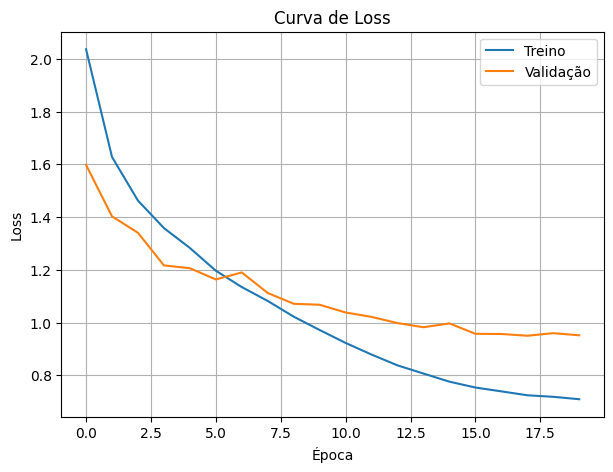

In [12]:
# Definir dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

# Instanciar o modelo
backbone = torchvision.models.efficientnet_b0(pretrained=True)
backbone = nn.Sequential(*list(backbone.children())[:-2])  # remove avgpool e fc
model = SuperClass20Model(backbone, embedding_dim=1280, n_head1=20, n_head2=100).to(device)

# Definir otimizador e função de perda
optimizer = torch.optim.Adam([
    {'params': model.backbone.parameters(), 'lr': 1e-3},   # backbone
    {'params': list(model.head.parameters()), 'lr': 1e-2}  # heads
])
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    total, correct20 = 0, 0

    for imgs, target100, target20 in tqdm(dataloader, desc="Treinando", leave=False):
        imgs, target20, target100 = imgs.to(device), target20.to(device), target100.to(device)

        optimizer.zero_grad()
        out20 = model(imgs)

        loss = criterion(out20, target20)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total += imgs.size(0)
        correct20 += (out20.argmax(1) == target20).sum().item()

    acc20 = 100 * correct20 / total
    return running_loss / len(dataloader), acc20

def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    total, correct20 = 0, 0

    with torch.no_grad():
        for imgs, target100, target20 in dataloader:
            imgs, target20 = imgs.to(device), target20.to(device)
            out20 = model(imgs)

            loss = criterion(out20, target20)

            running_loss += loss.item()
            total += imgs.size(0)
            correct20 += (out20.argmax(1) == target20).sum().item()

    acc20 = 100 * correct20 / total
    return running_loss / len(dataloader), acc20

# Loop principal de treino
num_epochs = 20

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

best_acc20 = 0.0
patience, counter = 10, 0

history = {'train_loss': [], 'val_loss': []}

for epoch in range(num_epochs):
    train_loss, train_acc20 = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc20 = evaluate(model, val_loader, criterion)

    scheduler.step()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    print(f"🌟 Época {epoch+1}/{num_epochs}")
    print(f"Treino: loss={train_loss:.4f}, acc20={train_acc20:.2f}%")
    print(f"Validação: loss={val_loss:.4f}, acc20={val_acc20:.2f}%")
    
    if val_acc20 > best_acc20:
        best_acc20 = val_acc20
        counter = 0
        torch.save(model, "best_super_class_model.pt")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break
        

with open('history_super_class.json', 'w') as f:
    json.dump(history, f)
    
plt.figure(figsize=(7,5))
plt.plot(history['train_loss'], label='Treino')
plt.plot(history['val_loss'], label='Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curva de Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png')
plt.show()

## 100 Class Model

Usando: cuda


/home/carlos/Desktop/trabalho_1_RN/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/carlos/Desktop/trabalho_1_RN/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🌟 Época 1/20
Treino: loss=3.8275, acc100=16.16%
Validação: loss=2.9189, acc20=35.71%


🌟 Época 2/20
Treino: loss=3.0547, acc100=32.85%
Validação: loss=2.4331, acc20=50.36%


🌟 Época 3/20
Treino: loss=2.6793, acc100=44.42%
Validação: loss=2.2115, acc20=56.70%


🌟 Época 4/20
Treino: loss=2.4342, acc100=51.80%
Validação: loss=2.0941, acc20=60.12%


🌟 Época 5/20
Treino: loss=2.2706, acc100=56.88%
Validação: loss=2.0102, acc20=63.14%


🌟 Época 6/20
Treino: loss=2.1237, acc100=61.53%
Validação: loss=1.8882, acc20=66.65%


🌟 Época 7/20
Treino: loss=2.0018, acc100=65.62%
Validação: loss=1.8729, acc20=67.25%


🌟 Época 8/20
Treino: loss=1.8837, acc100=69.10%
Validação: loss=1.7661, acc20=70.43%


🌟 Época 9/20
Treino: loss=1.7736, acc100=72.41%
Validação: loss=1.7177, acc20=71.24%


🌟 Época 10/20
Treino: loss=1.6729, acc100=75.11%
Validação: loss=1.6560, acc20=73.18%


🌟 Época 11/20
Treino: loss=1.5816, acc100=77.88%
Validação: loss=1.6007, acc20=74.06%


🌟 Época 12/20
Treino: loss=1.5027, acc100=80.47%
Validação: loss=1.6019, acc20=75.03%


🌟 Época 13/20
Treino: loss=1.4220, acc100=82.88%
Validação: loss=1.5601, acc20=76.16%


🌟 Época 14/20
Treino: loss=1.3588, acc100=84.67%
Validação: loss=1.5380, acc20=76.88%


🌟 Época 15/20
Treino: loss=1.2953, acc100=86.86%
Validação: loss=1.5175, acc20=77.90%


🌟 Época 16/20
Treino: loss=1.2492, acc100=88.48%
Validação: loss=1.4873, acc20=78.20%


🌟 Época 17/20
Treino: loss=1.2129, acc100=89.63%
Validação: loss=1.4918, acc20=78.31%


🌟 Época 18/20
Treino: loss=1.1908, acc100=90.22%
Validação: loss=1.4832, acc20=78.44%


🌟 Época 19/20
Treino: loss=1.1754, acc100=90.78%
Validação: loss=1.4742, acc20=78.73%


🌟 Época 20/20
Treino: loss=1.1659, acc100=91.18%
Validação: loss=1.4570, acc20=79.26%


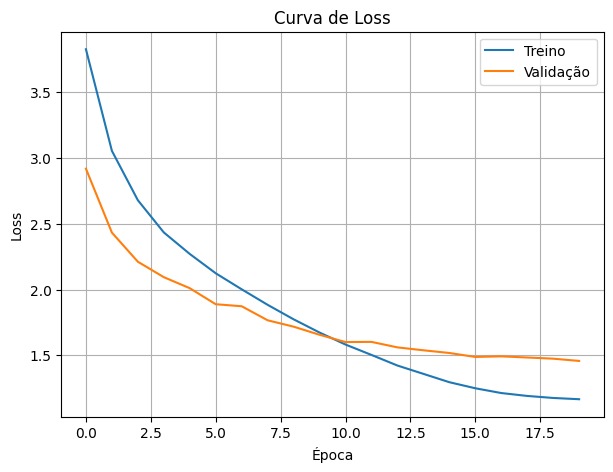

In [10]:
# Definir dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

# Instanciar o modelo
backbone = torchvision.models.efficientnet_b0(pretrained=True)
backbone = nn.Sequential(*list(backbone.children())[:-2])  # remove avgpool e fc
model = Class100Model(backbone, embedding_dim=1280, n_head=100, ).to(device)

# Definir otimizador e função de perda
optimizer = torch.optim.Adam([
    {'params': model.backbone.parameters(), 'lr': 1e-3},   # backbone
    {'params': list(model.head.parameters()), 'lr': 1e-2}  # heads
])
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    total, correct100 = 0, 0

    for imgs, target100, target20 in tqdm(dataloader, desc="Treinando", leave=False):
        imgs, target20, target100 = imgs.to(device), target20.to(device), target100.to(device)

        optimizer.zero_grad()
        out100 = model(imgs)

        loss = criterion(out100, target100)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total += imgs.size(0)
        correct100 += (out100.argmax(1) == target100).sum().item()

    acc100 = 100 * correct100 / total
    return running_loss / len(dataloader), acc100

def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    total, correct100 = 0, 0

    with torch.no_grad():
        for imgs, target100, target20 in dataloader:
            imgs, target100 = imgs.to(device), target100.to(device)
            out100 = model(imgs)

            loss = criterion(out100, target100)

            running_loss += loss.item()
            total += imgs.size(0)
            correct100 += (out100.argmax(1) == target100).sum().item()

    acc100 = 100 * correct100 / total
    return running_loss / len(dataloader), acc100

# Loop principal de treino
num_epochs = 20

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

best_acc100 = 0.0
patience, counter = 10, 0

history = {'train_loss': [], 'val_loss': []}

for epoch in range(num_epochs):
    train_loss, train_acc100 = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc100 = evaluate(model, val_loader, criterion)

    scheduler.step()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    print(f"🌟 Época {epoch+1}/{num_epochs}")
    print(f"Treino: loss={train_loss:.4f}, acc100={train_acc100:.2f}%")
    print(f"Validação: loss={val_loss:.4f}, acc20={val_acc100:.2f}%")
    
    if val_acc100 > best_acc100:
        best_acc100 = val_acc100
        counter = 0
        torch.save(model, "best_100_class_model.pt")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break
        

with open('history_100_class.json', 'w') as f:
    json.dump(history, f)
    
plt.figure(figsize=(7,5))
plt.plot(history['train_loss'], label='Treino')
plt.plot(history['val_loss'], label='Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curva de Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve_100_class.png')
plt.show()

# Validação

In [1]:
import matplotlib.pyplot as plt
import torch
import random

## Multi-head Model

In [12]:
model = torch.load("best_multihead_model.pt")

/tmp/ipykernel_12221/1912261771.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("best_multihead_model.pt")


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

MultiHeadModel(
  (backbone): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activa

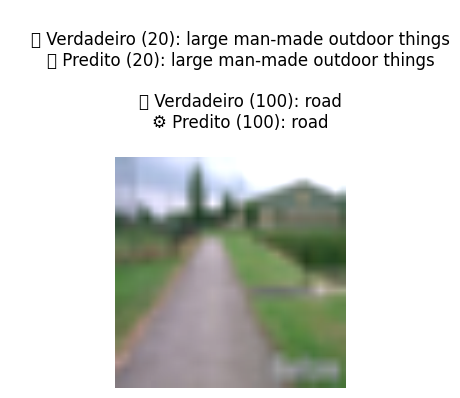

In [27]:

# Coloca o modelo em modo de avaliação
model.eval()

# Listas de nomes das classes do CIFAR-100
classes100 = trainset.classes

# Nomes das 20 superclasses, na mesma ordem usada no super_map
superclasses = [
    "aquatic mammals", "fish", "flowers", "food containers",
    "fruit and vegetables", "household electrical devices",
    "household furniture", "insects", "large carnivores",
    "large man-made outdoor things", "large natural outdoor scenes",
    "large omnivores and herbivores", "medium-sized mammals",
    "non-insect invertebrates", "people", "reptiles",
    "small mammals", "trees", "vehicles 1", "vehicles 2"
]

def show_random_prediction(model, dataset, device):
    # Escolhe uma imagem aleatória do dataset de teste
    idx = random.randint(0, len(dataset)-1)
    img, target100, target20 = dataset[idx]

    # Prepara o tensor para o modelo
    model.eval()
    with torch.no_grad():
        inp = img.unsqueeze(0).to(device)
        out20, out100 = model(inp)
        pred20 = out20.argmax(1).item()
        pred100 = out100.argmax(1).item()

    # Converte a imagem de volta para formato visual (unnormalize)
    mean = torch.tensor([0.5071, 0.4867, 0.4408]).view(3,1,1)
    std = torch.tensor([0.2675, 0.2565, 0.2761]).view(3,1,1)
    img_vis = img * std + mean
    img_vis = img_vis.permute(1, 2, 0).clamp(0, 1)

    # Mostra a imagem e as predições
    plt.figure(figsize=(3,3))
    plt.imshow(img_vis)
    plt.axis("off")
    plt.title(f"""
    🔹 Verdadeiro (20): {superclasses[target20]}
    🔸 Predito (20): {superclasses[pred20]}

    ✅ Verdadeiro (100): {classes100[target100]}
    ⚙️ Predito (100): {classes100[pred100]}
    """)
    plt.show()

# Exemplo de uso
show_random_prediction(model, testset, device)


## Super Class Model

In [15]:
# Coloca o modelo em modo de avaliação
model.eval()

# Nomes das 20 superclasses, na mesma ordem usada no super_map
superclasses = [
    "aquatic mammals", "fish", "flowers", "food containers",
    "fruit and vegetables", "household electrical devices",
    "household furniture", "insects", "large carnivores",
    "large man-made outdoor things", "large natural outdoor scenes",
    "large omnivores and herbivores", "medium-sized mammals",
    "non-insect invertebrates", "people", "reptiles",
    "small mammals", "trees", "vehicles 1", "vehicles 2"
]

def show_random_prediction(model, dataset, device):
    # Escolhe uma imagem aleatória do dataset de teste
    idx = random.randint(0, len(dataset)-1)
    img, target100, target20 = dataset[idx]

    # Prepara o tensor para o modelo
    model.eval()
    with torch.no_grad():
        inp = img.unsqueeze(0).to(device)
        out20 = model(inp)
        pred20 = out20.argmax(1).item()

    # Converte a imagem de volta para formato visual (unnormalize)
    mean = torch.tensor([0.5071, 0.4867, 0.4408]).view(3,1,1)
    std = torch.tensor([0.2675, 0.2565, 0.2761]).view(3,1,1)
    img_vis = img * std + mean
    img_vis = img_vis.permute(1, 2, 0).clamp(0, 1)

    # Mostra a imagem e as predições
    plt.figure(figsize=(3,3))
    plt.imshow(img_vis)
    plt.axis("off")
    plt.title(f"""
    🔹 Verdadeiro (20): {superclasses[target20]}
    🔸 Predito (20): {superclasses[pred20]}
    """)
    plt.show()

# Exemplo de uso
show_random_prediction(model, testset, device)

AttributeError: 'tuple' object has no attribute 'argmax'

# Métricas

In [28]:
from sklearn.metrics import classification_report


## Multi-Head Model

In [29]:
import torch

model.eval()
all_true20, all_pred20 = [], []
all_true100, all_pred100 = [], []

with torch.no_grad():
    for imgs, target100, target20 in test_loader:
        imgs = imgs.to(device)
        target20 = target20.to(device)
        target100 = target100.to(device)

        out20, out100 = model(imgs)

        preds20 = out20.argmax(1)
        preds100 = out100.argmax(1)

        # Armazena no CPU para uso pelo sklearn
        all_true20.extend(target20.cpu().numpy())
        all_pred20.extend(preds20.cpu().numpy())
        all_true100.extend(target100.cpu().numpy())
        all_pred100.extend(preds100.cpu().numpy())


In [35]:
# Relatório das 20 superclasses
print("=== Relatório - 20 Superclasses ===")
report = classification_report(all_true20, all_pred20, digits=3)

with open("classification_report_cifar100_20.txt", "w") as f:
    f.write(report)


=== Relatório - 20 Superclasses ===


In [34]:
# Relatório das 100 classes
print("\n=== Relatório - 100 Classes ===")
report = classification_report(all_true100, all_pred100, digits=3)

with open("classification_report_cifar100.txt", "w") as f:
    f.write(report)


=== Relatório - 100 Classes ===


## Super class Model

In [ ]:
model_super_class = torch.load("best_super_class_model.pt")

model.to(device)

In [53]:
import torch

model_super_class.eval()
all_true20, all_pred20 = [], []
all_true100, all_pred100 = [], []

with torch.no_grad():
    for imgs, target100, target20 in test_loader:
        imgs = imgs.to(device)
        target20 = target20.to(device)

        out20 = model_super_class(imgs)

        preds = out20.argmax(dim=1)

        # Armazena no CPU para uso pelo sklearn
        all_true20.extend(target20.cpu().numpy())
        all_pred20.extend(preds.cpu().numpy())

In [55]:
# Relatório das 20 superclasses
print("=== Relatório - 20 Superclasses ===")
report = classification_report(all_true20, all_pred20, digits=3)

with open("classification_report_cifar100_20_super_model.txt", "w") as f:
    f.write(report)

=== Relatório - 20 Superclasses ===


## 100 Classes Model

In [58]:
model_100_classes = torch.load("best_100_class_model.pt")

model_100_classes.to(device)

/tmp/ipykernel_12221/65775050.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_100_classes = torch.load("best_100_class_model.pt")


Class100Model(
  (backbone): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activat

In [59]:
import torch

model_super_class.eval()
all_true100, all_pred100 = [], []

with torch.no_grad():
    for imgs, target100, target20 in test_loader:
        imgs = imgs.to(device)
        target100 = target100.to(device)

        out100 = model_100_classes(imgs)

        preds = out100.argmax(dim=1)

        # Armazena no CPU para uso pelo sklearn
        all_true100.extend(target100.cpu().numpy())
        all_pred100.extend(preds.cpu().numpy())

In [60]:
# Relatório das 20 superclasses
print("=== Relatório - 20 Superclasses ===")
report = classification_report(all_true20, all_pred20, digits=3)

with open("classification_report_cifar100_100_classes_model.txt", "w") as f:
    f.write(report)

=== Relatório - 20 Superclasses ===
